<a href="https://colab.research.google.com/github/layeleomehta/Self-Driving-Car-Simulation/blob/master/Self_Driving_Car_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone --depth 1 https://github.com/rslim087a/track

In [2]:
# Common libraries
# !pip install scikit-learn numpy matplotlib pandas opencv-python

# PyTorch (non-GPU version, replace with 'torch' and 'torchvision' for GPU)
# !pip install --user torchvision # torch

# PyTorch with CUDA
# !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu121

In [3]:
# import torch
# print(f'PyTorch version: {torch.__version__}')
# print('*'*10)
# print(f'_CUDA version: ')

# !nvcc --version
# print('*'*10)
# print(f'CUDNN version: {torch.backends.cudnn.version()}')
# print(f'Available GPU devices: {torch.cuda.device_count()}')
# print(f'Device Name: {torch.cuda.get_device_name()}')

In [4]:
import os
import random
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.transforms import functional as tvF
from torchvision.transforms.functional import gaussian_blur

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- Cloning image data collected from Rayan Slim's github. The data was collected by the simulator by manually driving the car three rounds forward and three backwards. 
- Installing and importing several libraries. 


In [5]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [6]:
def path_leaf(path):
  # _, tail = os.path.split(path)
  # return tail
    return path.split('\\')[-1]
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


- 'path_leaf()' function is using the ntpath library to separate the path into a head and tail component. Then it's returning just the tail component, to eliminate the extraneous directory paths. 
- The 'path_leaf()' function is applied to the center, left and right images, and the first 5 elements in the changed 'data' variable are shown. 

array([-0.96, -0.88, -0.8 , -0.72, -0.64, -0.56, -0.48, -0.4 , -0.32,
       -0.24, -0.16, -0.08,  0.  ,  0.08,  0.16,  0.24,  0.32,  0.4 ,
        0.48,  0.56,  0.64,  0.72,  0.8 ,  0.88,  0.96])

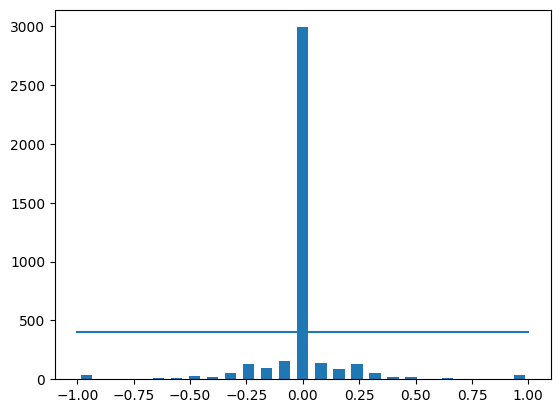

In [7]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
center

- Using the numpy library, a histogram is plotted showing the frequency of the steering data categorized into 25 bins, according to the 'num_bins' variable. The return values are stored in the 'hist' variable (which stores the histogram, and the bins variable (which returns the length of the bin edges). 
- The center' variable centers the steering data around 0. This is important, as 0 means that the car is not steering. 
- This newly centered data is plotted on a histogram using the 'bar()' function from the matplotlib pyplot library. The centered data is a range of steering values, plotted along the x axis of the histogram. 
- Looking at the frequency distribution of steering values, since there are a lot of zeroes, this can bias the car towards steering straight all the time (if this data is used to train the model). Therefore, a 'samples_per_bin' variable is initialized, which is used to specify the maximum number of samples each bin can have. Since every other bin has below 400 steering angle occurences, this will limit the zero values to 400. 
- To visualize this 'samples_per_bin' cutoff, the 'plot()' function is used from the matplotlib pyplot library, which plots a line from the lowest steering value to the highest steering value at a height of 400. 



Total data: 4053
Removed: 2590
Remaining: 1463


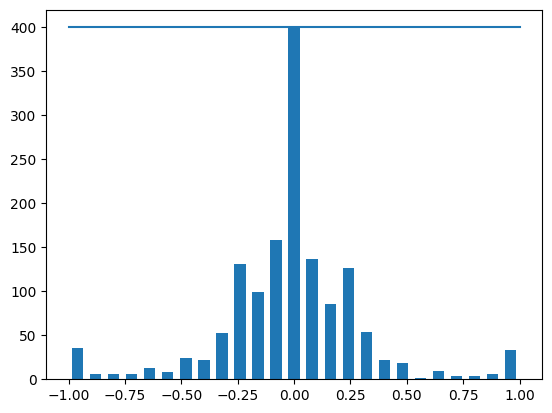

In [8]:
print('Total data:', len(data))

remove_list = []
for j in range(num_bins):
    # Filter the steering data between the current bin edges
    mask = (data['steering'] >= bins[j]) & (data['steering'] <= bins[j+1])
    filtered_indices = data[mask].index
    # Shuffle the filtered indices
    shuffled_indices = shuffle(filtered_indices, random_state=1)
    # Select the indices to remove
    remove_indices = shuffled_indices[samples_per_bin:]
    remove_list.extend(remove_indices)

print('Removed:', len(remove_list))
data.drop(index=remove_list, inplace=True)
print('Remaining:', len(data))

# Recalculate the histogram with the remaining data
hist, bin_edges = np.histogram(data['steering'], bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5  # Compute the center of each bin
plt.bar(bin_centers, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

In [9]:
data.head()

,center,left,right,steering,throttle,reverse,speed
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.00,0.000000,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.00,0.000000,0.0,0.615438
6,center_2018_07_16_17_11_43_998.jpg,left_2018_07_16_17_11_43_998.jpg,right_2018_07_16_17_11_43_998.jpg,0.00,0.000000,0.0,0.606834
10,center_2018_07_16_17_11_44_274.jpg,left_2018_07_16_17_11_44_274.jpg,right_2018_07_16_17_11_44_274.jpg,0.00,0.202773,0.0,0.707000
12,center_2018_07_16_17_11_44_413.jpg,left_2018_07_16_17_11_44_413.jpg,right_2018_07_16_17_11_44_413.jpg,-0.05,0.642727,0.0,1.434013


In [10]:
print(data.iloc[30])

def load_img_steering(datadir, df):
    image_path = []
    steering = []
    adjustment = 0.15  # Define the steering angle adjustment for left and right images

    for center, left, right, steer in zip(df['center'], df['left'], df['right'], df['steering']):
        # Center image and steering
        image_path.append(str(os.path.join(datadir, 'IMG', center.strip())))
        # image_path.append(str(center).strip())
        steering.append(float(steer))
        # Left image and adjusted steering
        image_path.append(str(os.path.join(datadir, 'IMG', left.strip())))
        # image_path.append(str(left).strip())
        steering.append(float(steer) + adjustment)
        # Right image and adjusted steering
        image_path.append(str(os.path.join(datadir, 'IMG', right.strip())))
        # image_path.append(str(right).strip())
        steering.append(float(steer) - adjustment)

    print(image_path[0], steering[0])
    image_paths = np.asarray(image_path, dtype=str)
    steerings = np.asarray(steering, dtype=np.float32) # NOTE: Was float64
    return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir, data)
print(image_paths[0], steerings[0])
print(steerings.dtype)

center      center_2018_07_16_17_11_46_873.jpg
left          left_2018_07_16_17_11_46_873.jpg
right        right_2018_07_16_17_11_46_873.jpg
steering                             -0.371641
throttle                                   1.0
reverse                                    0.0
speed                                 26.62703
Name: 44, dtype: object
track\IMG\center_2018_07_16_17_11_43_792.jpg 0.0
track\IMG\center_2018_07_16_17_11_43_792.jpg 0.0
float32


Training Samples: 3511
Validation Samples: 878


Text(0.5, 1.0, 'Validation set')

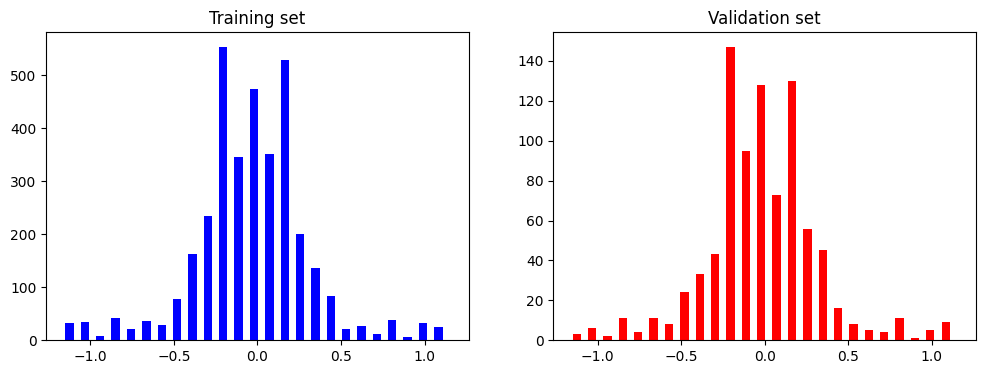

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [12]:
def rgb_to_yuv(image):
    """
    Convert an RGB image to YUV.
    Args:
    - image: A PyTorch tensor of shape (C, H, W) in the range [0, 1].
    Returns:
    - A PyTorch tensor of the image in YUV color space.
    """
    if image.dim() == 4:  # Batch of images
        c = image.shape[1]
        assert c == 3, "Input images must have 3 channels"
    elif image.dim() == 3:  # Single image
        c = image.shape[0]
        assert c == 3, "Input image must have 3 channels"
    
    # Coefficients for converting RGB to YUV
    # These coefficients are from the BT.601 standard, which is commonly used
    matrix = torch.tensor([
        [0.299, -0.14713, 0.615],
        [0.587, -0.28886, -0.51499],
        [0.114, 0.436, -0.10001]
    ]).to(image.device)

    # Reshape the image to (C, H*W) for matrix multiplication
    reshaped_img = image.view(c, -1)
    
    # Perform the matrix multiplication and then reshape back to (C, H, W)
    yuv_image = torch.matmul(matrix, reshaped_img).view(c, *image.shape[1:])

    # # Reorder dimensions if input was a batch
    # if image.dim() == 4:
    #     print("Reordering dimensions...")
    #     yuv_image = yuv_image.permute(1, 0, 2, 3)
    
    return yuv_image

def img_preprocess_tensor(img_tensor):
    # Assuming img_tensor is a PyTorch tensor in (C, H, W) format
    # Crop
    img_tensor = img_tensor[:, 60:135, :]
    
    # Convert color space if needed - this would require custom implementation or prior conversion
    img_tensor = rgb_to_yuv(img_tensor)

    # Apply Gaussian blur
    img_tensor = gaussian_blur(img_tensor, kernel_size=[3, 3])
    
    # Resize
    img_tensor = transforms.Resize((66, 200))(img_tensor)
    
    # Normalize
    # img_tensor = img_tensor / 255.0
    return img_tensor

class TransformBoth:
    def __init__(self, brightness=0.2, flip_prob=0.5, affine_scale=(1, 1.3), translate=(0.1, 0.1)):
        self.brightness = brightness
        self.flip_prob = flip_prob
        self.affine_scale = affine_scale
        self.translate = translate

    def __call__(self, image, steering: float) -> Tuple[torch.Tensor, float] :
        # Convert numpy array or a torch tensor to PIL Image if not already
        # image = F.to_pil_image(image)

        # Apply random affine transformation with zoom and translation
        width, height = image.size
        max_dx = self.translate[0] * width
        max_dy = self.translate[1] * height
        translations = (np.random.uniform(-max_dx, max_dx), np.random.uniform(-max_dy, max_dy))
        
        scale = random.uniform(*self.affine_scale)
        image = tvF.affine(image, angle=0, translate=translations, scale=scale, shear=0)

        # Apply random horizontal flip
        if random.random() < self.flip_prob:
            image = tvF.hflip(image)

            # Invert the steering angle too
            steering = -steering

        # Apply random change in brightness
        image = tvF.adjust_brightness(image, brightness_factor=random.uniform(1-self.brightness, 1+self.brightness))

        # Convert PIL Image back to tensor
        image = tvF.to_tensor(image)

        return image, steering

class MyDrivingDataset(Dataset):
    def __init__(self, image_paths, steering_angles, transform=None):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        steering_angle = self.steering_angles[idx]

        if self.transform:
            image, steering_angle = self.transform(image, steering_angle)
            
         # Check if image is a PIL Image, convert to tensor if so
        if isinstance(image, Image.Image):
            image = self.to_tensor(image)
            
        # Some more preprocessing which will also be applied during inference
        image = img_preprocess_tensor(image)

        return image, steering_angle

torch.Size([3, 66, 200])
torch.float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


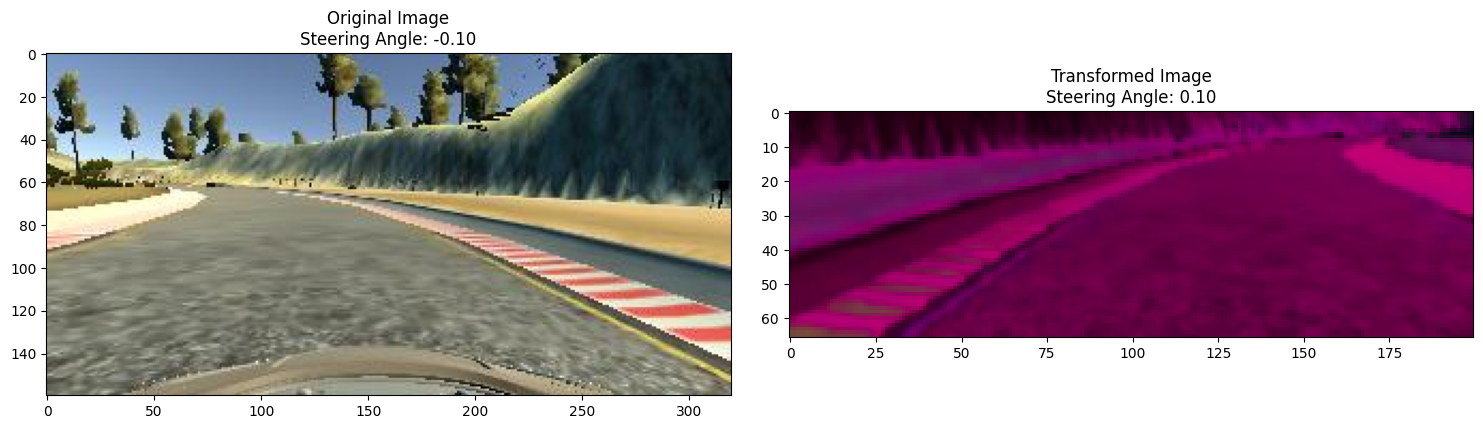

In [13]:
# Test the dataset and transformations

transform_both = TransformBoth()
dataset = MyDrivingDataset(image_paths, steerings, transform=transform_both)
print(dataset[141][0].shape)
print(dataset[141][0].dtype)

idx = random.randint(0, 1000)
original_image = mpimg.imread(image_paths[idx])
original_steering = steerings[idx]

transformed_image, transformed_steering = dataset[idx]

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image\nSteering Angle: {:.2f}'.format(original_steering))

axs[1].imshow(transformed_image.permute(1, 2, 0))
axs[1].set_title('Transformed Image\nSteering Angle: {:.2f}'.format(transformed_steering))

plt.show()

In [14]:
# Define the DataLoaders
from torch.utils.data import DataLoader

batch_size = 32
train_dataset = MyDrivingDataset(X_train, y_train, transform=TransformBoth())
valid_dataset = MyDrivingDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [15]:
# Define the model
import torch.nn as nn
import torch.nn.functional as nnF

class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)

        self.fc1 = nn.Linear(3*6*64, 100) # Adjust number of input features
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nnF.elu(self.conv1(x))
        x = nnF.elu(self.conv2(x))
        x = nnF.elu(self.conv3(x))
        x = nnF.elu(self.conv4(x))
        x = nnF.elu(self.conv5(x))

        # x = x.view(-1, 64*2*33) # Flatten the tensor
        # x = torch.flatten(x)
        x = x.view(x.size(0), -1)

        x = nnF.elu(self.fc1(x))
        # x = self.dropout(x)
        x = nnF.elu(self.fc2(x))
        # x = self.dropout(x)
        x = nnF.elu(self.fc3(x))
        # x = self.dropout(x)

        # Output layer
        x = self.fc4(x)

        return x
    
model = NvidiaModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [17]:
# Training loop
n_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}/{n_epochs}")
    # Training
    model.train()
    train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        print(f"Epoch: {epoch+1}, Batch: {i+1}")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        if (i+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}')
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'model_local.pth')

Epoch: 1/10


In [ ]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()